## Setup

In [1]:
# Load packages
library(dplyr)
library(ggplot2)
library(zoo)
library(fixest)
library(tidyr)
library(broom)
library(stringr)
library(purrr)

# Load data
df <- read.csv("/Users/julienmbarki/Documents/Doctorat/Publications/Article 4/Data/Code/data_requests/tiktok_streams.csv") #nolint


Warning message in sprintf(gettext(fmt, domain = domain), ...):
"un argument est inutilis'e par le format '? avec la version R %s'"
Warning message:
"? avec la version R 'dplyr'"

Attachement du package : 'dplyr'


Les objets suivants sont masqu'es depuis 'package:stats':

    filter, lag


Les objets suivants sont masqu'es depuis 'package:base':

    intersect, setdiff, setequal, union



Attachement du package : 'zoo'


Les objets suivants sont masqu'es depuis 'package:base':

    as.Date, as.Date.numeric


Warning message in sprintf(gettext(fmt, domain = domain), ...):
"un argument est inutilis'e par le format '? avec la version R %s'"
Warning message:
"? avec la version R 'fixest'"
Warning message in sprintf(gettext(fmt, domain = domain), ...):
"un argument est inutilis'e par le format '? avec la version R %s'"
Warning message:
"? avec la version R 'stringr'"
Warning message in sprintf(gettext(fmt, domain = domain), ...):
"un argument est inutilis'e par le format '? avec la version

## Cleaning and Data management

In [2]:
# Convert dates to proper format
df <- df %>%
    mutate(
        artist_video_date = as.Date(artist_video_date),
        stream_date = as.Date(stream_date),
        tiktok_stream_date = as.Date(tiktok_stream_date)
    ) %>%
    arrange(track_id, stream_date)

df <- df %>%
    group_by(track_id) %>%
    filter(any(!is.na(spotify_streams))) %>%
    ungroup()

# Create event time
df <- df %>%
    mutate(
        event_time = as.numeric(stream_date - artist_video_date),
        event_time_2 = as.numeric(tiktok_stream_date - artist_video_date)
    )
table(df$event_time)
table(df$event_time_2)



-45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 
179 179 179 180 180 180 180 179 177 180 181 179 180 181 183 184 185 186 185 185 
-25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6 
187 185 185 188 189 189 187 193 195 196 199 199 199 201 204 203 205 207 209 210 
 -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 
211 215 217 219 222 226 232 241 239 245 246 247 246 247 248 249 249 248 250 248 
 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34 
246 248 251 250 251 249 250 249 250 250 250 250 250 251 250 249 250 251 249 251 
 35  36  37  38  39  40  41  42  43  44 
250 249 249 251 249 252 251 250 252 252 


-571  -46  -45  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35  -34  -33  -32 
  88  433 1620  151  123  111  117  111  112  110  139  117  116  445  202  204 
 -31  -30  -29  -28  -27  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17  -16 
 269  168  178  188  239  176  140  171  116  176   71  167  195  158  148  237 
 -15  -14  -13  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3   -2   -1    0 
 152  192  150  380  207  222  185  210  163  219  143  235  231  296  157  228 
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
 221  237  244  200  261  208  287  240  266  243  237  194  283  187  253  173 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 170  186  175  137  164  187  192  178   97  162  191  203  248  301  190  151 
  33   34   35   36   37   38   39   40   41   42   43   44   48   56   80   86 
 219  161  262  163  183  177  147  170  195  196  141  145   43   90   56   44 
  93  100  278  292  381  4

### Spotify Streams

In [3]:
# Keep track_ids that have an observation at event_time = -10
valid_tracks <- df %>%
    filter(event_time == -20) %>%
    pull(track_id) %>%
    unique()

df_clean <- df %>%
    filter(track_id %in% valid_tracks)

# Interpolate missing values per track
df_clean <- df_clean %>%
    group_by(track_id) %>%
    complete(
        event_time = seq(min(event_time, na.rm = TRUE),
        max(event_time, na.rm = TRUE), by = 1)
    ) %>%
    arrange(track_id, event_time)
table(df_clean$event_time)

df_clean <- df_clean %>%
    group_by(track_id) %>%
    filter(sum(!is.na(spotify_streams)) >= 2) %>%
    mutate(
        streams = zoo::na.approx(spotify_streams, na.rm = FALSE)
    ) %>%
    ungroup()



-45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 
178 178 178 179 179 179 179 179 179 179 180 181 181 182 183 183 184 185 185 185 
-25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6 
186 186 186 188 188 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 
 -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 
189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 
 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34 
189 189 189 189 189 189 189 189 189 189 189 189 189 189 188 188 188 188 188 188 
 35  36  37  38  39  40  41  42  43  44 
188 188 188 188 188 188 188 188 188 188 

In [4]:
# Create daily new streams
df_clean <- df_clean %>%
    group_by(track_id) %>%
    arrange(track_id, stream_date) %>%
    mutate(daily_streams = streams - lag(streams, default = first(streams))) %>%
    ungroup()
summary(df_clean$daily_streams)

# Remove tracks with negative daily streams
problem_tracks <- df_clean %>%
    group_by(track_id) %>%
    filter(any(daily_streams < 0)) %>%
    pull(track_id) %>%
    unique()

df_clean <- df_clean %>%
    filter(!track_id %in% problem_tracks)

# Log transform daily new streams
df_clean <- df_clean %>%
    mutate(log_daily_streams = log1p(daily_streams))
summary(df_clean$log_daily_streams)


      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-136637126        344      10501     268945     108945   13007836 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   5.553   9.177   8.319  11.216  16.068 

In [5]:
# Create a new variable based on artist_video
df_clean <- df_clean %>%
    mutate(
        video_clean = ifelse(
            artist_video == "True",
            1, 0
        )
    )
table(df_clean$video_clean, useNA = "always")

# Filter to remove NA
df_clean <- df_clean %>%
    filter(!is.na(video_clean))
table(df_clean$video_clean, useNA = "always")

# Clean artist followers
df_clean <- df_clean %>%
    mutate(
        artist_followers = str_extract_all(artist_followers, "\\d+") %>%
        map(as.numeric) %>%  # Convert to numeric
        map_dbl(~ ifelse(all(is.na(.x)), NA,  # If all are NA, return NA
        ifelse(any(is.na(.x)), max(.x, na.rm = TRUE), mean(.x))))
    )  # Handle None & compute
summary(df_clean$artist_followers)



    0     1  <NA> 
10696  4258     0 


    0     1  <NA> 
10696  4258     0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
     359    39300   249700  3445805  1800000 66200000     5926 

### TikTok Streams

In [12]:
# Keep track_ids that have an observation at event_time = -10
valid_tracks_2 <- df %>%
    filter(event_time_2 == -16) %>%
    pull(track_id) %>%
    unique()

df_clean_2 <- df %>%
    filter(track_id %in% valid_tracks_2)

# Interpolate missing values per track
df_clean_2 <- df_clean_2 %>%
    group_by(track_id) %>%
    complete(
        event_time_2 = seq(min(event_time_2, na.rm = TRUE),
        max(event_time_2, na.rm = TRUE), by = 1)
    ) %>%
    arrange(track_id, event_time_2)
table(df_clean_2$event_time_2)

df_clean_2 <- df_clean_2 %>%
    group_by(track_id) %>%
    filter(sum(!is.na(tiktok_streams)) >= 2) %>%
    mutate(
        streams = zoo::na.approx(tiktok_streams, na.rm = FALSE)
    ) %>%
    ungroup()



 -46  -45  -44  -43  -42  -41  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31 
 323 1557  117  118  111  111  111  110  111  134  112  112  445  201  207  265 
 -30  -29  -28  -27  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17  -16  -15 
 166  135  210  166  176  141  216  172  144  141  192  189  145  145  237  147 
 -14  -13  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3   -2   -1    0    1 
 148  147  147  147  147  147  148  148  148  147  147  148  148  147  148  148 
   2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17 
 148  147  148  148  145  147  146  147  146  146  146  146  147  145  144  144 
  18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33 
 144  143  144  143  142  144  144  143  144  143  142  143  144  143  142  142 
  34   35   36   37   38   39   40   41   42   43   44 
 142  141  142  141  143  140  142  141  141  136   76 

In [13]:
# Create daily new streams
df_clean_2 <- df_clean_2 %>%
    group_by(track_id) %>%
    arrange(track_id, tiktok_stream_date) %>%
    mutate(
        daily_streams_tiktok = tiktok_streams -
        lag(tiktok_streams, default = first(tiktok_streams))
    ) %>%
    ungroup()
summary(df_clean_2$daily_streams_tiktok)

# Remove tracks with negative daily streams
problem_tracks_2 <- df_clean_2 %>%
    group_by(track_id) %>%
    filter(any(daily_streams_tiktok < 0)) %>%
    pull(track_id) %>%
    unique()

df_clean_2 <- df_clean_2 %>%
    filter(!track_id %in% problem_tracks_2)

# Log transform daily new streams
df_clean_2 <- df_clean_2 %>%
    mutate(log_daily_streams_tiktok = log1p(daily_streams_tiktok))
summary(df_clean_2$log_daily_streams_tiktok)


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-6054600        0      600     3533     2200  6055400     5126 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   6.686   5.067   7.784  13.122    3674 

In [14]:
# Create a new variable based on artist_video
df_clean_2 <- df_clean_2 %>%
    mutate(
        video_clean = ifelse(
            artist_video == "True",
            1, 0
        )
    )
table(df_clean_2$video_clean, useNA = "always")

# Filter to remove NA
df_clean_2 <- df_clean_2 %>%
    filter(!is.na(video_clean))
table(df_clean_2$video_clean, useNA = "always")

# Clean artist followers
df_clean_2 <- df_clean_2 %>%
    mutate(
        artist_followers = str_extract_all(artist_followers, "\\d+") %>%
        map(as.numeric) %>%  # Convert to numeric
        map_dbl(~ ifelse(all(is.na(.x)), NA,  # If all are NA, return NA
        ifelse(any(is.na(.x)), max(.x, na.rm = TRUE), mean(.x))))
    )  # Handle None & compute
summary(df_clean_2$artist_followers)



   0    1 <NA> 
7276 2124 1530 


   0    1 <NA> 
7276 2124    0 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
     687    49200   379600  4414322  2500000 66200000     4815 

## Plots

### Spotify Streams

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


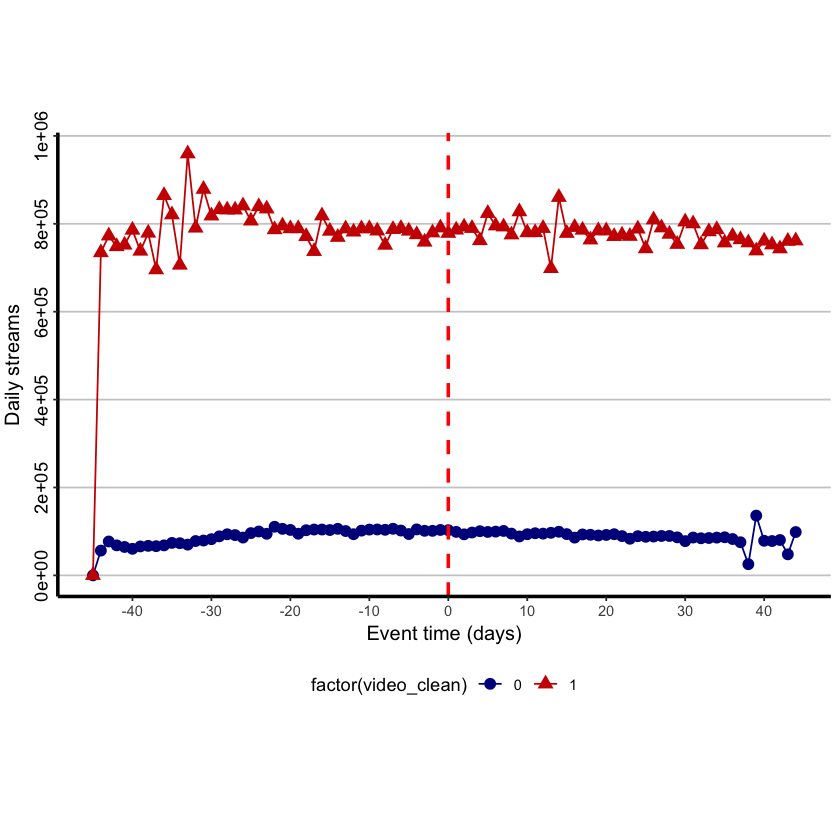

In [6]:
# Plot the time series stream by artist type
df_time_series <- df_clean %>%
    group_by(event_time, video_clean) %>%
    summarise(
        mean_daily_streams = mean(daily_streams, na.rm = TRUE),
        .groups = "drop"
    )

ggplot(
    df_time_series,
    aes(
        x = event_time,
        y = mean_daily_streams,
        color = factor(video_clean),
        shape = factor(video_clean)
    )) +
    geom_line(size = 0.5) +
    geom_point(aes(shape = factor(video_clean)), size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red", size = 1) +
    labs(
        x = "Event time (days)",
        y = "Daily streams",
    ) +
    scale_color_manual(values = c("0" = "blue4", "1" = "red3")) +
    scale_shape_manual(values = c(16, 17)) +
    scale_y_continuous(
        breaks = scales::pretty_breaks(n = 6)
    ) +
    scale_x_continuous(
        breaks = scales::pretty_breaks(n = 10)
    ) +
    theme(
        panel.background = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = "gray80"),
        axis.title.y = element_text(vjust = +2, size = 12),
        axis.title.x = element_text(vjust = 0.5, size = 12),
        axis.line.x = element_line(linewidth = 1, color = "black"),
        axis.line.y = element_line(linewidth = 1, color = "black"),
        axis.text.y = element_text(
            angle = 90,
            color = "black",
            size = 11,
            face = 1,
            hjust = 0.5
        ),
        aspect.ratio = 0.6,
        legend.position = "bottom",
    )

# Save the plot
ggsave(
    "time_series_streams.png",
    width = 8,
    height = 5,
    dpi = 300
)


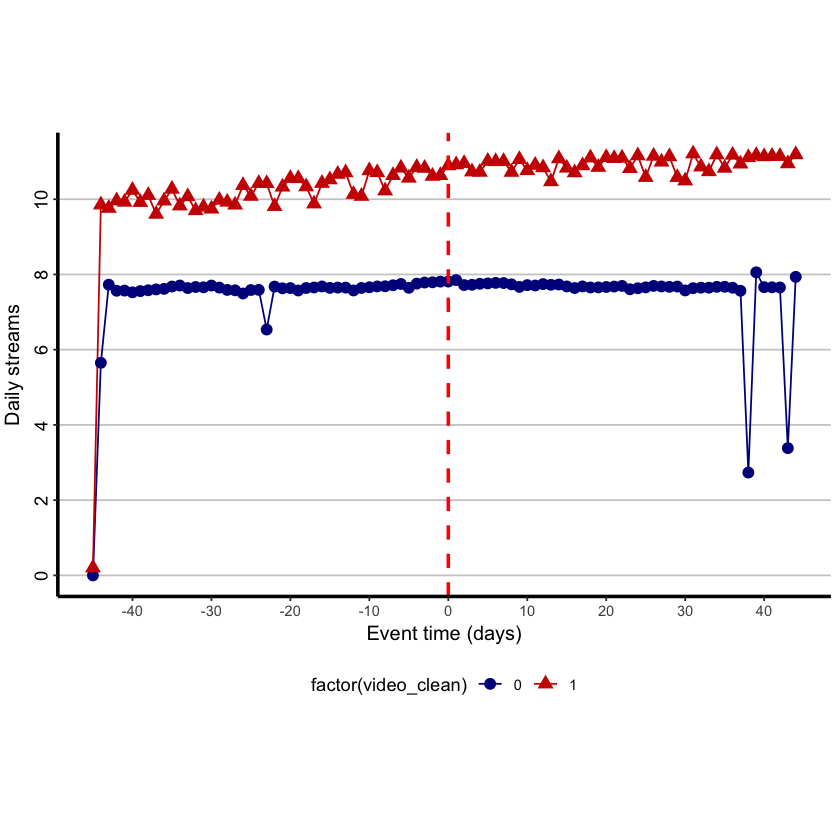

In [7]:
# Plot the time series stream by artist type
df_time_series <- df_clean %>%
    group_by(event_time, video_clean) %>%
    summarise(
        mean_daily_streams = mean(log_daily_streams, na.rm = TRUE),
        .groups = "drop"
    )

ggplot(
    df_time_series,
    aes(
        x = event_time,
        y = mean_daily_streams,
        color = factor(video_clean),
        shape = factor(video_clean)
    )) +
    geom_line(size = 0.5) +
    geom_point(aes(shape = factor(video_clean)), size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red", size = 1) +
    labs(
        x = "Event time (days)",
        y = "Daily streams",
    ) +
    scale_color_manual(values = c("0" = "blue4", "1" = "red3")) +
    scale_shape_manual(values = c(16, 17)) +
    scale_y_continuous(
        breaks = scales::pretty_breaks(n = 6)
    ) +
    scale_x_continuous(
        breaks = scales::pretty_breaks(n = 10)
    ) +
    theme(
        panel.background = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_line(color = "gray80"),
        axis.title.y = element_text(vjust = +2, size = 12),
        axis.title.x = element_text(vjust = 0.5, size = 12),
        axis.line.x = element_line(linewidth = 1, color = "black"),
        axis.line.y = element_line(linewidth = 1, color = "black"),
        axis.text.y = element_text(
            angle = 90,
            color = "black",
            size = 11,
            face = 1,
            hjust = 0.5
        ),
        aspect.ratio = 0.6,
        legend.position = "bottom",
    )

# Save the plot
ggsave(
    "time_series_log_streams.png",
    width = 8,
    height = 5,
    dpi = 300
)


## Parallel trends

In [8]:
# Parallel trends Spotify
df_pre <- df_clean %>%
    filter(event_time < 0 & event_time > -20) %>%
    mutate(
        videos_f = as.factor(video_clean),
        event_time_f = relevel(as.factor(event_time), ref = "-1")
    )

parallel_trends <- feols(
    log_daily_streams ~ event_time_f * videos_f + track_position +
    artist_followers |
    stream_date + track_genres + label_type + track_date,
    data = df_pre,
    cluster = ~ track_id
)
summary(parallel_trends)


NOTE: 1,254 observations removed because of NA values (RHS: 1,254).



OLS estimation, Dep. Var.: log_daily_streams
Observations: 1,919 
Fixed-effects: stream_date: 292,  track_genres: 41,  label_type: 22,  track_date: 95
Standard-errors: Clustered (track_id) 
                            Estimate Std. Error   t value   Pr(>|t|)    
event_time_f-19           -13.027588   1.711008 -7.613984 1.7577e-11 ***
event_time_f-18           -12.041477   1.621945 -7.424099 4.3979e-11 ***
event_time_f-17           -11.358879   1.529462 -7.426714 4.3428e-11 ***
event_time_f-16           -10.857287   1.437930 -7.550635 2.3882e-11 ***
event_time_f-15            -9.926071   1.376994 -7.208506 1.2373e-10 ***
event_time_f-14            -9.147524   1.302510 -7.022996 2.9934e-10 ***
event_time_f-13            -8.522803   1.254401 -6.794321 8.8123e-10 ***
event_time_f-12            -7.732578   1.082299 -7.144587 1.6788e-10 ***
event_time_f-11            -6.945328   0.976593 -7.111791 1.9627e-10 ***
event_time_f-10            -6.466157   0.888261 -7.279569 8.8060e-11 ***
event_t

In [ ]:
# Parallel trends TikTok
df_pre <- df_clean_2 %>%
    filter(event_time_2 < 0 & event_time_2 > -10) %>%
    mutate(
        videos_f = as.factor(video_clean),
        event_time_f = relevel(as.factor(event_time_2), ref = "-1")
    )

parallel_trends <- feols(
    log_daily_streams_tiktok ~ event_time_f * videos_f + track_position +
    artist_followers |
    tiktok_stream_date + track_genres + label_type + track_date,
    data = df_pre,
    cluster = ~ track_id
)
summary(parallel_trends)


## Models

### DiD

In [9]:
# Main Model Spotify
df_model <- df_clean %>%
    filter(event_time != 0 & event_time >= -20) %>%
    mutate(
        videos_f = as.factor(video_clean),
        event_time_f = relevel(as.factor(event_time), ref = "-1"),
        post = ifelse(event_time > 0, 1, 0),
        treated = ifelse(videos_f == 1, 1, 0)
    )

# Estimate the DiD model with fixed effects
did_model <- feols(
    log_daily_streams ~ treated * post + track_position |
    stream_date + track_genres + label_type + track_date,
    data = df_model,
    cluster = ~ track_id
)

# Display the results
summary(did_model)


OLS estimation, Dep. Var.: log_daily_streams
Observations: 10,688 
Fixed-effects: stream_date: 600,  track_genres: 54,  label_type: 27,  track_date: 155
Standard-errors: Clustered (track_id) 
                Estimate Std. Error   t value  Pr(>|t|)    
treated         8.333439   0.420190 19.832526 < 2.2e-16 ***
post            0.393016   0.227548  1.727177 0.0860418 .  
track_position -0.040184   0.014799 -2.715349 0.0073388 ** 
treated:post    0.089912   0.118719  0.757347 0.4499419    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.27954     Adj. R2: 0.892249
                Within R2: 0.376681

In [15]:
# Main Model TikTok
df_model <- df_clean_2 %>%
    filter(event_time_2 != 0 & event_time_2 > -10) %>%
    mutate(
        videos_f = as.factor(video_clean),
        event_time_f = relevel(as.factor(event_time_2), ref = "-1"),
        post = ifelse(event_time_2 > 0, 1, 0),
        treated = ifelse(videos_f == 1, 1, 0)
    )

# Estimate the DiD model with fixed effects
did_model <- feols(
    log_daily_streams_tiktok ~ treated * post + track_position |
    tiktok_stream_date + track_genres + label_type + track_date,
    data = df_model,
    cluster = ~ track_id
)

# Display the results
summary(did_model)


The variable 'treated' has been removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_daily_streams_tiktok
Observations: 4,239 
Fixed-effects: tiktok_stream_date: 415,  track_genres: 42,  label_type: 18,  track_date: 98
Standard-errors: Clustered (track_id) 
                Estimate Std. Error   t value  Pr(>|t|)    
post            0.685737   0.765022  0.896363 0.3721290    
track_position  0.015097   0.003958  3.814756 0.0002316 ***
treated:post   -0.368029   0.583028 -0.631238 0.5292701    
... 1 variable was removed because of collinearity (treated)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.91398     Adj. R2: 0.687715
                Within R2: 0.016121

### Event Study

In [ ]:
# Main Model Spotify
df_model <- df_clean %>%
    filter(event_time != 0 & event_time >= -20) %>%
    mutate(
        videos_f = as.factor(video_clean),
        event_time_f = relevel(as.factor(event_time), ref = "-1"),
        post = ifelse(event_time > 0, 1, 0),
        treated = ifelse(videos_f == 1, 1, 0)
    )

# Estimate the DiD model with fixed effects
event_study <- feols(
    log_daily_streams ~ event_time_f * post + track_position |
    stream_date + track_genres + label_type + track_date,
    data = df_model,
    cluster = ~ track_id
)

# Display the results
summary(event_study)


ERROR: Error in feols(log_daily_streams_tiktok ~ event_time_f * videos_f + track_position | : The variable 'log_daily_streams_tiktok' is in the LHS of the formula but not in the data set.


In [19]:
# Main Model TikTok
df_model <- df_clean_2 %>%
    filter(event_time_2 != 0 & event_time_2 > -16) %>%
    mutate(
        videos_f = as.factor(video_clean),
        event_time_f = relevel(as.factor(event_time_2), ref = "-1"),
        post = ifelse(event_time_2 > 0, 1, 0),
        treated = ifelse(videos_f == 1, 1, 0)
    )

# Estimate the DiD model with fixed effects
event_study <- feols(
    log_daily_streams_tiktok ~ event_time_f * videos_f + track_position |
    tiktok_stream_date + track_genres + label_type + track_date,
    data = df_model,
    cluster = ~ track_id
)

# Display the results
summary(event_study)


NOTE: 1 observation removed because of NA values (LHS: 1).

The variables 'videos_f1', 'event_time_f16:videos_f1' and three others have been removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_daily_streams_tiktok
Observations: 4,844 
Fixed-effects: tiktok_stream_date: 452,  track_genres: 42,  label_type: 18,  track_date: 98
Standard-errors: Clustered (track_id) 
                             Estimate   Std. Error    t value   Pr(>|t|)    
event_time_f-15             10.339346     2.733813   3.782024 2.6004e-04 ***
event_time_f-14              9.834294     2.883680   3.410328 9.2481e-04 ***
event_time_f-13              9.088125     2.781836   3.266952 1.4732e-03 ** 
event_time_f-12              8.272971     2.670960   3.097377 2.5104e-03 ** 
event_time_f-11              7.504686     2.779137   2.700365 8.0871e-03 ** 
event_time_f-10              4.887353     2.911883   1.678417 9.6268e-02 .  
event_time_f-9               6.578883     2.732290   2.407828 1.7809e-02 *  
event_time_f-8               5.933389     2.764666   2.146150 3.4187e-02 *  
event_time_f-7               6.295039     2.804573   2.244562 2.6914e-02 *  
event_time_f-6            